<a href="https://colab.research.google.com/github/ntminh981/ApplyParallelProgramming_Group5/blob/main/sequential/PoissonMatting_sequential.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Poisson matting
## Algorithm
1. Initialize alpha, foreground and background values. Alpha = 1 foreground, 0.5 unknown, 0 background. Approximate foreground and background  in unknown region by correspponding nearest known pixel. Smooth the F_B image with Gaussian filter to supress significant changes due to noise and inaccurate estimation.
2. Reconstruct alpha by solving Poisson equation using many iterations of Gauss-Seidel, with overrelaxation.
3. F,B refinement. Set new definite foreground and background based on alpha > 0.95 and alpha < 0.05  respectively. Update unknown F, B using new nearest known F, B pixels and apply another Gaussian filter.

Iterate steps 2,3 untill change in matting results is small or no new Foreground or background pixels are found in step 3.


In [ ]:
from __future__ import division
import numpy as np
import scipy.misc
import scipy.ndimage
import matplotlib.pyplot as plt
import cv2
import time
from numba import jit

In [ ]:
img = scipy.misc.imread('troll.png')
gray_img = scipy.misc.imread('troll.png', flatten='True')
trimap = scipy.misc.imread('trollTrimap.bmp', flatten='True')
# scale = 0.1
# img = scipy.misc.imresize(img, scale)
# gray_img = scipy.misc.imresize(gray_img, scale)
# trimap = scipy.misc.imresize(trimap, scale)
h, w ,c  = img.shape

In [ ]:
fg = trimap == 255
bg = trimap == 0
unknown = True ^ np.logical_or(fg,bg)
img = img
fg_img = gray_img*fg
bg_img = gray_img*bg
alphaEstimate = fg + 0.5 * unknown

In [ ]:
approx_bg = cv2.inpaint(bg_img.astype(np.uint8),(unknown +fg ).astype(np.uint8)*255,3,cv2.INPAINT_TELEA)*(np.logical_not(fg)).astype(np.float32)
approx_fg = cv2.inpaint(fg_img.astype(np.uint8),(unknown +bg ).astype(np.uint8)*255,3,cv2.INPAINT_TELEA)*(np.logical_not(bg)).astype(np.float32)

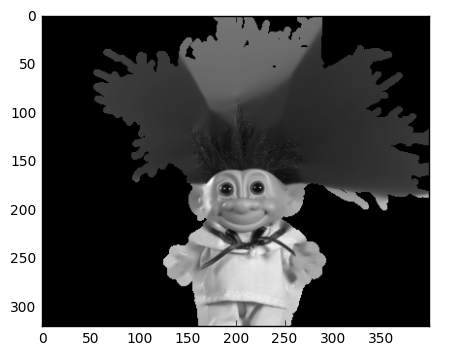

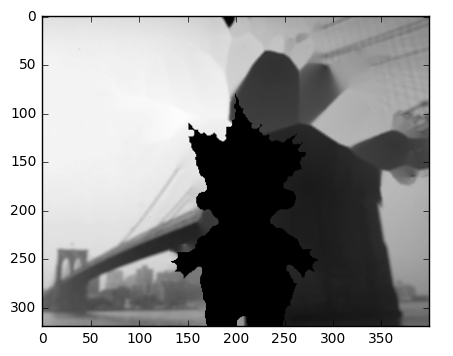

In [ ]:
plt.imshow(approx_fg, cmap='gray')
plt.show()
plt.imshow(approx_bg, cmap='gray')
plt.show()

In [ ]:
# Smooth F - B image
approx_diff = approx_fg - approx_bg
approx_diff = scipy.ndimage.filters.gaussian_filter(approx_diff, 0.9)

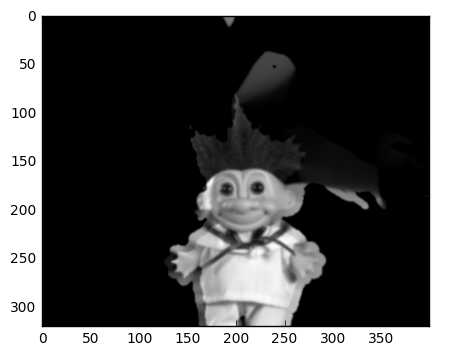

In [ ]:
plt.imshow(np.minimum(np.maximum(approx_diff,0),255), cmap='gray')
plt.show()

Poisson Equation
$$\Delta \alpha = div \frac{\nabla I}{F-B}$$
![](https://wikimedia.org/api/rest_v1/media/math/render/svg/9ae5cade73b31dee0e04eb21b1e6e13b5944ef41)
Gauss seidel method
![ig](https://wikimedia.org/api/rest_v1/media/math/render/svg/02f26444f4da61ae84a9824a6b5292949a483fcc)

In [ ]:
dy, dx = np.gradient(gray_img)

In [ ]:
d2y, _ = np.gradient(dy/approx_diff)
_, d2x = np.gradient(dx/approx_diff)

In [ ]:
b = d2y + d2x

In [ ]:
def computeAlphaSlow(alpha, b):
    alphaNew = alpha.copy()
    alphaOld = np.zeros(alphaNew.shape)
    threshold = 0.1
    n = 1
    while (n < 50 and np.sum(np.abs(alphaNew - alphaOld)) > threshold):
        alphaOld = alphaNew.copy()
        for i in range(1, h-1):
            for j in range(1, w-1):
                if(unknown[i,j]):
                    alphaNew[i,j] = 1/4  * (alphaNew[i-1 ,j] + alphaNew[i,j-1] + alphaOld[i, j+1] + alphaOld[i+1,j] - b[i,j])
        n +=1
    return alphaNew

In [ ]:
@jit
def computeAlphaJit(alpha, b):
    alphaNew = alpha.copy()
    alphaOld = np.zeros(alphaNew.shape)
    threshold = 0.1
    n = 1
    while (n < 50 and np.sum(np.abs(alphaNew - alphaOld)) > threshold):
        alphaOld = alphaNew.copy()
        for i in range(1, h-1):
            for j in range(1, w-1):
                if(unknown[i,j]):
                    alphaNew[i,j] = 1/4  * (alphaNew[i-1 ,j] + alphaNew[i,j-1] + alphaOld[i, j+1] + alphaOld[i+1,j] - b[i,j])
        n +=1
    return alphaNew

In [ ]:
def computeAlpha(alpha, b):
    alphaNew = alpha.copy()
    alphaOld = np.zeros(alphaNew.shape)
    threshold = 0.1
    n = 1
    ca = np.transpose(np.nonzero(unknown))
    c = ca[ (ca[:,0]>=1) & (ca[:,0]<h-1) &  (ca[:,1]>=1) & (ca[:,1]<w-1)]
    c0 = c[:,0]
    c1 = c[:,1]
    while (n < 50 and np.sum(np.abs(alphaNew - alphaOld)) > threshold):
        alphaOld = alphaNew.copy()
        alphaNew[c0, c1] = 1/4  * (alphaNew[c0 -1, c1] + alphaNew[c0, c1 -1] + alphaOld[c0,c1+1] + alphaOld[c0+1,c1] - b[c0,c1])
        n +=1
    return alphaNew

In [ ]:
%timeit computeAlphaSlow(alphaEstimate, b)
%timeit computeAlphaJit(alphaEstimate, b)
%timeit computeAlpha(alphaEstimate, b)

1 loop, best of 3: 2.11 s per loop
10 loops, best of 3: 25.6 ms per loop
10 loops, best of 3: 63.4 ms per loop


In [ ]:
alpha = computeAlphaJit(alphaEstimate, b)
alpha = np.minimum(np.maximum(alphaNew,0),1).reshape(h,w)

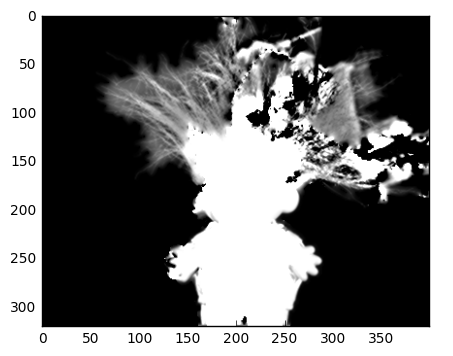

In [ ]:
plt.imshow(alpha, cmap='gray')
plt.show()

In [ ]:
scipy.misc.imsave('trollAlpha.png', alpha)

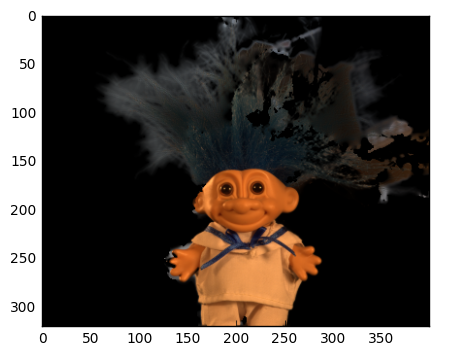

In [ ]:
plt.imshow((alpha.reshape(h,w,1).repeat(3,2)*img).astype(np.uint8))
plt.show()